### ISS VSE CA2 Part2

#### By: Kenneth Goh (A0198544N), Raymond Ng (A0198543R), Tan Heng Han (A0198502B)

In [83]:
import cv2
import os
import math
import time
import pickle
from collections import Counter
from itertools import repeat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from glob import glob
from tqdm import tqdm

from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.regularizers import l2

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

### Config

In [144]:
# Config
modelInWidth = 368
modelInHeight = 368
TEST_SIZE = 0.2
BATCH_SIZE = 2
EPOCH = 200
labels = ['NotPushUps', 'PushUps']

### Load and slice videos for training
Slice training videos into 5hz frames for model input
Data set:
1. Push up videos
2. Mixture of non push up videos

In [85]:
# Get filenames and labels for data
data_path = 'data'
files = pd.DataFrame()
filenames = []
filelabels = []
for lbl in labels:
    for ext in ('*.avi', '*.mp4'):
        path = os.path.join(data_path, lbl)
        filename = glob(os.path.join(path, ext))
        if filename: filenames.append(filename)
        if filename: 
            for idx in range(len(filename)):
                filelabels.append(lbl)

files['video_name'] = [item for sublist in filenames for item in sublist]
files['video_label'] = filelabels
files

,video_name,video_label
0,data\NotPushUps\v_PullUps_g02_c01.avi,NotPushUps
1,data\NotPushUps\v_PullUps_g03_c04.avi,NotPushUps
2,data\PushUps\0Q5nKgu2bmM.mp4,PushUps
3,data\PushUps\2vZAl9Ylt64.mp4,PushUps
4,data\PushUps\4s6xVt9PPIM.mp4,PushUps


In [96]:
def tryCreateVideoFolder(folderName):
    try:
        path = os.path.join('data/images/', folderName)
        if not os.path.isdir(path):
            os.mkdir(path)
    except:
        print(f'Creation of directory {folderName} failed')

In [98]:
# Slice and store the frames from training videos
for i in tqdm(range(files.shape[0])):
    count = 0
    tryCreateVideoFolder(files['video_label'][i])
    videoFile = files['video_name'][i]
    cap = cv2.VideoCapture(videoFile)   # capturing the video from the given path
    frameRate = cap.get(5) #frame rate
    while(cap.isOpened()):
        frameId = cap.get(1) #current frame number
        ret, frame = cap.read()
        if (ret != True):
            break
        if (frameId % 2 == 0):
            # storing the frames in a new folder named train_1
            filename ='data/images/' + files['video_label'][i] + '/' + videoFile.split('\\')[2].replace('.avi','').replace('.mp4','') +"_frame%d.jpg" % count;count+=1
            cv2.imwrite(filename, frame)
    cap.release()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.19s/it]


In [133]:
%%time
# Read each images and their label into a dataframe
frames_n_labels = pd.DataFrame(columns=['frame', 'label'])
images_dir = glob('data/images/*/')
for idir in images_dir:
    iclss = idir.split('\\')[1]
    ifiles = glob(idir + '/*.jpg')
    for idx in tqdm(range(len(ifiles))):
        frame = cv2.imread(ifiles[idx])
        frames_n_labels = frames_n_labels.append(
            {'frame': frame,
             'label': iclss}, ignore_index=True)
frames_n_labels.shape

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 575/575 [00:04<00:00, 134.43it/s]

Wall time: 5.26 s


(886, 2)

Text(0.5, 1.0, 'Frame Distribution')

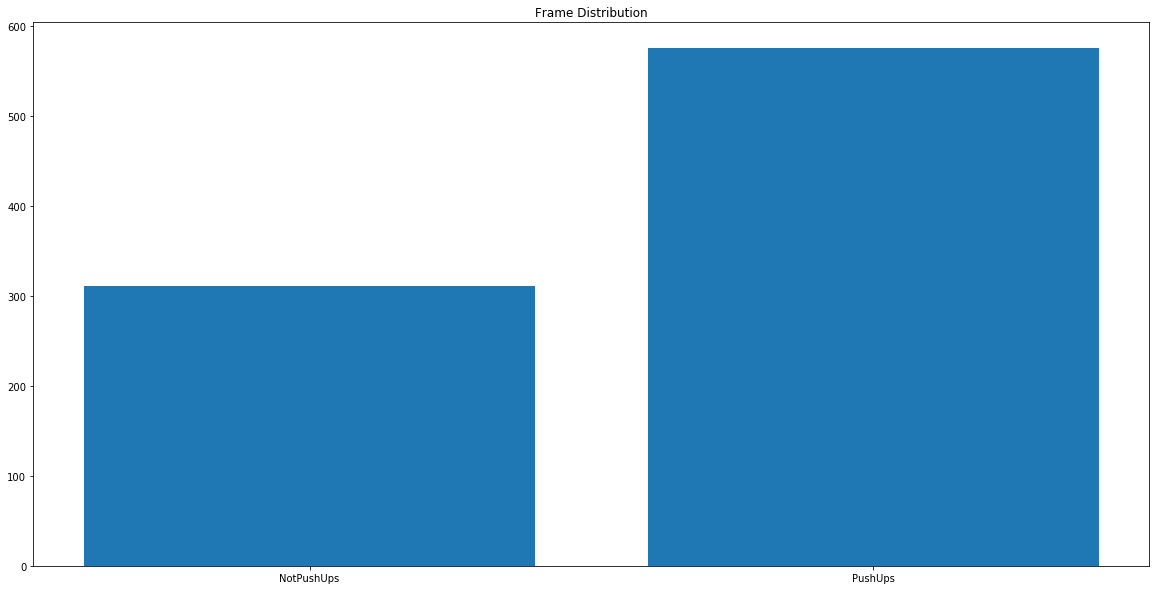

In [134]:
label_count = Counter(frames_n_labels['label'])
plt.figure(figsize=(20,10))
plt.bar(label_count.keys(), label_count.values())
plt.title('Frame Distribution')

### Load OpenPose models

#### Instructions to get openpose models
1. Clone https://github.com/CMU-Perceptual-Computing-Lab/openpose
2. Open a console and run **openpose/models/getModels.bat**
3. Copy contents from **openpose/models/pose/coco** to **Model/coco**

In [135]:
PROTO_FILE = 'Model/coco/pose_deploy_linevec.prototxt'
WEIGHTS_FILE = 'Model/coco/pose_iter_440000.caffemodel'
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }
POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

In [136]:
# Load openpose model via Opencv
try:
    net = cv2.dnn.readNetFromCaffe(PROTO_FILE, WEIGHTS_FILE)
except:
    raise Exception('Error reading model, check model proto and weights file.')

### Run Openpose inference for each frame
Save heat maps for training

In [15]:
%%time
netout = []
for idx in tqdm(range(len(frames_n_labels['frame']))):
    currFrame = frames_n_labels['frame'][idx]
    inBlob = cv2.dnn.blobFromImage(currFrame, 1.0/255, (modelInWidth, modelInHeight), (0,0,0), swapRB=False, crop=False)
    net.setInput(inBlob)
    netout.append(np.swapaxes(np.squeeze(net.forward(), axis=0),0,2)) # shape=(46,46,57)

100%|████████████████████████████████████████████████████████████████████████████████| 11136/11136 [3:21:27<00:00,  1.09s/it]


Wall time: 3h 21min 58s


### Pickle netout and load back

In [32]:
%%time
with open('pose.pickle','wb') as f:
    pickle.dump([frames_n_labels, netout], f)

In [137]:
%%time
with open('pose.pickle','rb') as f:
    frames_n_labels, netout = pickle.load(f)

Wall time: 5.06 s


### Check image and pose

In [138]:
# Get random image
ridx = np.random.randint(len(netout)-1)
testout = np.swapaxes(netout[ridx],2,0) # shape=(57,46,46)
testimg = frames_n_labels['frame'][ridx]
frameWidth = testimg.shape[1]
frameHeight = testimg.shape[0]

In [139]:
points = []
for i in range(len(BODY_PARTS)):
    # Slice heatmap of corresponging body's part.
    heatMap = testout[i, :, :]
 
    # Originally, we try to find all the local maximums. To simplify a sample
    # we just find a global one. However only a single pose at the same time
    # could be detected this way.
    _, conf, _, point = cv2.minMaxLoc(heatMap)
    x = (frameWidth * point[0]) / testout.shape[2]
    y = (frameHeight * point[1]) / testout.shape[1]
 
    # Add a point if it's confidence is higher than threshold.
    points.append((int(x), int(y)) if conf > 0.1 else None)

In [140]:
for pair in POSE_PAIRS:
    partFrom = pair[0]
    partTo = pair[1]
    assert(partFrom in BODY_PARTS)
    assert(partTo in BODY_PARTS)
 
    idFrom = BODY_PARTS[partFrom]
    idTo = BODY_PARTS[partTo]
    if points[idFrom] and points[idTo]:
        cv2.line(testimg, points[idFrom], points[idTo], (255, 74, 0), 3)
        cv2.ellipse(testimg, points[idFrom], (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
        cv2.ellipse(testimg, points[idTo], (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
        cv2.putText(testimg, str(idFrom), points[idFrom], cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255),2,cv2.LINE_AA)
        cv2.putText(testimg, str(idTo), points[idTo], cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255),2,cv2.LINE_AA)

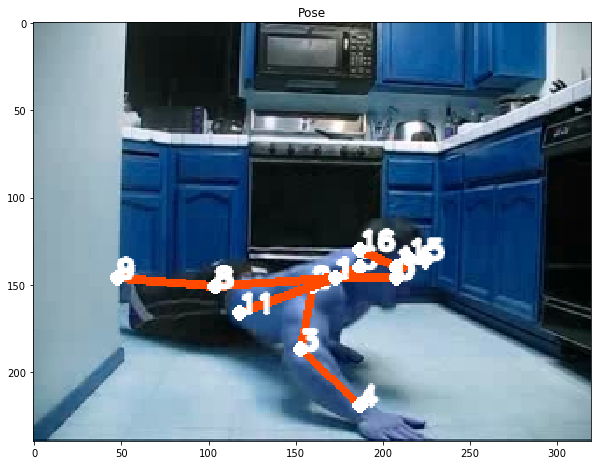

In [141]:
plt.figure(figsize=(10,10))
plt.imshow(testimg)
plt.title('Pose')
plt.show()

### Prepare training data

In [142]:
# Keep only joints keypoints and drop PAFs
for idx in range(len(netout)):
    netout[idx] = netout[idx][:,:,0:18]
netout_stk = np.stack(netout)

In [145]:
all_lbl = np.asarray(frames_n_labels['label'])
all_lbl = all_lbl.reshape(-1,1)
oh_lbl = OneHotEncoder(sparse=False).fit_transform(all_lbl)
print(f'Labels: [{labels[0]}, {labels[1]}]')
print(f'First Label: {all_lbl[0]}')
print(f'First One Hot Encode: {oh_lbl[0]}')

Labels: [NotPushUps, PushUps]
First Label: ['NotPushUps']
First One Hot Encode: [1. 0.]


In [146]:
# Train test split
trainData, testData, trainLabel, testLabel = train_test_split(netout_stk, oh_lbl, test_size=TEST_SIZE, random_state=42, shuffle=True)

In [147]:
print(f'trainData shape: {trainData.shape}')
print(f'testData shape: {testData.shape}')
print(f'trainLabel shape: {trainLabel.shape}')
print(f'testLabel shape: {testLabel.shape}')

trainData shape: (8908, 46, 46, 18)
testData shape: (2228, 46, 46, 18)
trainLabel shape: (8908, 2)
testLabel shape: (2228, 2)


### Training Model

In [183]:
def createModel(x, y, features):
    ipt = Input(shape=(x, y, features))

    x   = Conv2D(32, (3,3), padding='same', strides=(2,2))(ipt)
    x   = BatchNormalization()(x)
    x   = Activation('relu')(x)
    
    x   = Conv2D(32, (3,3), padding='same', strides=(2,2))(x)
    x   = BatchNormalization()(x)
    x   = Activation('relu')(x)
    
    x   = Conv2D(64, (3,3), padding='same', strides=(2,2))(x)
    x   = BatchNormalization()(x)
    x   = Activation('relu')(x)
    
    x   = Conv2D(64, (3,3), padding='same', strides=(2,2))(x)
    x   = BatchNormalization()(x)
    x   = Activation('relu')(x)
    x   = Dropout(0.5)(x)
       
    x   = Flatten()(x)
    x   = Dense(128, activation='relu', kernel_initializer=he_normal(42), kernel_regularizer=l2(0.001))(x)
    x   = Dense(64, activation='relu', kernel_initializer=he_normal(42), kernel_regularizer=l2(0.001))(x)
    x   = Dense(len(labels), activation='softmax')(x)
    
    model = Model(ipt, x)
    model.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(), 
                  metrics=['accuracy'])
    
    return model

In [181]:
xShape, yShape, featureShape = trainData[0].shape
trainModel = createModel(xShape, yShape, featureShape)
inferModel = createModel(xShape, yShape, featureShape)
trainModel.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 46, 46, 18)]      0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 23, 23, 32)        5216      
_________________________________________________________________
batch_normalization_44 (Batc (None, 23, 23, 32)        128       
_________________________________________________________________
activation_44 (Activation)   (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 12, 12, 32)        9248      
_________________________________________________________________
batch_normalization_45 (Batc (None, 12, 12, 32)        128       
_________________________________________________________________
activation_45 (Activation)   (None, 12, 12, 32)        0  

In [146]:
modelname = 'pose'
modelpath = os.path.join('Model', modelname+'.hdf5')
checkpoint = ModelCheckpoint(modelpath, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')
csv_logger = CSVLogger(modelname +'.csv')
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
reduceLr = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, mode='min')

callbacks_list  = [checkpoint, csv_logger, early_stop, reduceLr]

In [147]:
trainModel.fit(x=trainData, y=trainLabel,
              batch_size=BATCH_SIZE,
              validation_data=(testData,testLabel),
              epochs=EPOCH,
              callbacks=callbacks_list)

Train on 8908 samples, validate on 2228 samples
Epoch 1/200
8896/8908 [============================>.] - ETA: 0s - loss: 0.2425 - accuracy: 0.9673
Epoch 00001: val_loss improved from inf to 0.09160, saving model to Model\pose.hdf5
8908/8908 [==============================] - 28s 3ms/sample - loss: 0.2425 - accuracy: 0.9672 - val_loss: 0.0916 - val_accuracy: 0.9915
Epoch 2/200
8892/8908 [============================>.] - ETA: 0s - loss: 0.0742 - accuracy: 0.9874
Epoch 00002: val_loss improved from 0.09160 to 0.04499, saving model to Model\pose.hdf5
8908/8908 [==============================] - 30s 3ms/sample - loss: 0.0749 - accuracy: 0.9873 - val_loss: 0.0450 - val_accuracy: 0.9937
Epoch 3/200
8896/8908 [============================>.] - ETA: 0s - loss: 0.0418 - accuracy: 0.9917
Epoch 00003: val_loss improved from 0.04499 to 0.03904, saving model to Model\pose.hdf5
8908/8908 [==============================] - 29s 3ms/sample - loss: 0.0418 - accuracy: 0.9917 - val_loss: 0.0390 - val_accu

### Inference and test results

In [148]:
inferModel.load_weights(modelpath)
inferModel.compile(loss="categorical_crossentropy", 
                  optimizer=Adam(),
                  metrics=["accuracy"])

In [149]:
pred = inferModel.predict(testData, batch_size=BATCH_SIZE)
predout = np.argmax(pred, axis=1)
testout = np.argmax(testLabel, axis=1)

testScores = metrics.accuracy_score(testout, predout)
confusion  = metrics.confusion_matrix(testout, predout)

print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,predout,target_names=labels,digits=4))
print(confusion)

Best accuracy (on testing dataset): 99.73%
              precision    recall  f1-score   support

  NotPushUps     0.9986    0.9972    0.9979      1430
     PushUps     0.9950    0.9975    0.9962       798

    accuracy                         0.9973      2228
   macro avg     0.9968    0.9973    0.9971      2228
weighted avg     0.9973    0.9973    0.9973      2228

[[1426    4]
 [   2  796]]


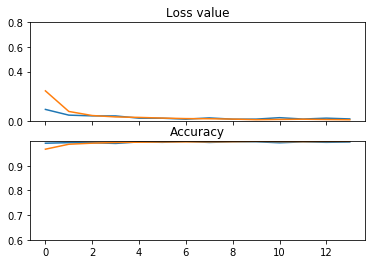

In [150]:
records = pd.read_csv(modelname +'.csv')
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'])
plt.plot(records['loss'])
plt.yticks([0.00,0.40,0.60,0.80])
plt.title('Loss value',fontsize=12)

ax = plt.gca()
ax.set_xticklabels([])

plt.subplot(212)
plt.plot(records['val_accuracy'])
plt.plot(records['accuracy'])
plt.yticks([0.6,0.7,0.8,0.9])
plt.title('Accuracy',fontsize=12)
plt.show()

### Run Video Prediction

In [157]:
videoPath = os.path.join('test_video', '0Q5nKgu2bmM.mp4')
outpath   = os.path.join('test_video', 'test7.mp4')
vs = cv2.VideoCapture(videoPath)
writer = None
(W,H) = (None, None)

In [158]:
frameCounter = 0
while True:
    (grabbed,
     frame)     = vs.read()
    frameCounter += 1
    if not grabbed:
        break
    # Initialization on the W and H
    if W is None or H is None:
        (H, W)  = frame.shape[:2]

    # Get the frame
    output      = frame.copy()
    frame       = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame       = cv2.resize(frame, (224, 224)).astype("float32")
#     frame      -= imgMean
    
    # Infer openpose
    input_blob = cv2.dnn.blobFromImage(frame, 1.0/255, (modelInWidth, modelInWidth), (0,0,0), swapRB=False, crop=False)
    net.setInput(input_blob)
    netout_org = net.forward()
    netout = np.swapaxes(np.squeeze(netout_org, axis=0),0,2)
    netout = netout[:,:,0:18] # 46, 46, 19
    
    # Perform prediction on the frame
    preds       = inferModel.predict(np.expand_dims(netout, axis=0))
    clss = np.argmax(preds)
    label = labels[clss]
    
    #########
    # ADD METHODS TO COUNT AND CHECK FOR CORRECTNESS HERE    
    #########
    
    text        = "Detected: {}".format(label)
    print(f'Frame {frameCounter} {text}')
    cv2.putText(output,
                text,
                (10,40),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.75,
                (0,255,0),
                5,
                cv2.LINE_AA)# This must be removed if requires real-time display

                            # Initialize the writer if this is not done
    if writer is None:
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        writer = cv2.VideoWriter(outpath,
                                 fourcc,
                                 30,
                                 (W, H),
                                 True)

                            # Write the output frame to disk
    writer.write(output)

                            # Real-time display the output image
#    cv2.imshow("Output", output)


print("Closing ...")
writer.release()
vs.release()

Preds [[0.00365006 0.99634993]]
Clss 1
Frame 1 Detected: PushUps
Preds [[0.0038416 0.9961584]]
Clss 1
Frame 2 Detected: PushUps
Preds [[0.00319039 0.99680954]]
Clss 1
Frame 3 Detected: PushUps
Preds [[8.7197986e-04 9.9912804e-01]]
Clss 1
Frame 4 Detected: PushUps
Preds [[8.9374103e-04 9.9910623e-01]]
Clss 1
Frame 5 Detected: PushUps
Preds [[4.4798001e-04 9.9955195e-01]]
Clss 1
Frame 6 Detected: PushUps
Preds [[4.9000705e-04 9.9951005e-01]]
Clss 1
Frame 7 Detected: PushUps
Preds [[8.3006558e-04 9.9916995e-01]]
Clss 1
Frame 8 Detected: PushUps
Preds [[0.00139911 0.9986009 ]]
Clss 1
Frame 9 Detected: PushUps
Preds [[5.7714834e-04 9.9942291e-01]]
Clss 1
Frame 10 Detected: PushUps
Preds [[8.73982e-04 9.99126e-01]]
Clss 1
Frame 11 Detected: PushUps
Preds [[5.0138094e-04 9.9949861e-01]]
Clss 1
Frame 12 Detected: PushUps
Preds [[9.154829e-04 9.990845e-01]]
Clss 1
Frame 13 Detected: PushUps
Preds [[7.314577e-04 9.992686e-01]]
Clss 1
Frame 14 Detected: PushUps
Preds [[0.00103155 0.9989685 ]]
Cls